# 02_study_replication.ipynb

## Project: Bitcoin in a 3-Asset Portfolio (BTC, S&P 500, Gold)

## Notebook 02 — Study Replication

---

### Objective:
This notebook aims to replicate the main results and findings from the study conducted by Philipp Schottler on Bitcoin's role in a diversified portfolio.

We will use the dataset created in `01_data_exploration.ipynb`, focusing exclusively on the period between September 2014 and November 2021, which corresponds to the original study's timeframe.

---

## Dataset used:

| Dataset | Period | Description |
|---------|--------|-------------|
| `final_df_study.csv` | 2014-09 to 2021-11 | Dataset aligned with the original study's time frame. |

---


In [2]:
import os
import time
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
# Crear carpeta temporal Spark
temp_path = os.path.join(os.getcwd(), 'spark-temp')
os.makedirs(temp_path, exist_ok=True)

# Definir variables de entorno
os.environ['JAVA_HOME'] = os.environ['CONDA_PREFIX'] + '\Library'
os.environ['SPARK_LOCAL_DIRS'] = temp_path

print('JAVA_HOME:', os.environ.get('JAVA_HOME'))
print('SPARK_LOCAL_DIRS:', os.environ.get('SPARK_LOCAL_DIRS'))

JAVA_HOME: C:\Users\TESTER\anaconda3\envs\btc_portfolio\Library
SPARK_LOCAL_DIRS: C:\Users\TESTER\Desktop\Laboral\GIT\btc-3-asset-portfolio-extension\notebooks\spark-temp


In [4]:
# Crear Spark Session y medir tiempo
start_time = time.time()

spark = SparkSession.builder \
.appName('btcproject') \
.config('spark.driver.memory', '512m') \
.config('spark.executor.memory', '512m') \
.config('spark.local.dir', temp_path) \
.getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

end_time = time.time()
print('Spark Version:', spark.version)
print(f'Tiempo total en crear SparkSession: {round(end_time - start_time, 2)} segundos')

Spark Version: 3.5.4
Tiempo total en crear SparkSession: 13.29 segundos


In [5]:
final_df_study = pd.read_csv("../data/final_df_study.csv")

print("Rows:", final_df_study.shape[0])
print("Columns:", final_df_study.shape[1])

print(final_df_study.info())
display(final_df_study.head(5))

Rows: 87
Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        87 non-null     object 
 1   close_btc    87 non-null     float64
 2   high_btc     87 non-null     float64
 3   low_btc      87 non-null     float64
 4   close_sp500  87 non-null     float64
 5   high_sp500   87 non-null     float64
 6   low_sp500    87 non-null     float64
 7   close_gold   87 non-null     float64
 8   high_gold    87 non-null     float64
 9   low_gold     87 non-null     float64
 10  avg_cpi      87 non-null     float64
dtypes: float64(10), object(1)
memory usage: 7.6+ KB
None


,month,close_btc,high_btc,low_btc,close_sp500,high_sp500,low_sp500,close_gold,high_gold,low_gold,avg_cpi
0,2014-09,386.944000,493.928009,372.239990,23.26,23.75,22.91,1207.83,1286.02,1207.83,100.93035
1,2014-10,338.321014,411.697998,289.295990,23.95,24.10,21.70,1171.52,1248.55,1170.79,100.91037
2,2014-11,378.046997,457.092987,320.626007,25.28,25.29,23.80,1165.88,1201.13,1140.71,100.72039
3,2014-12,320.192993,384.037994,304.231995,25.41,25.70,23.86,1186.83,1230.94,1173.87,100.40971
4,2015-01,217.464005,320.434998,171.509995,25.39,26.29,24.77,1283.56,1301.79,1188.11,99.77007


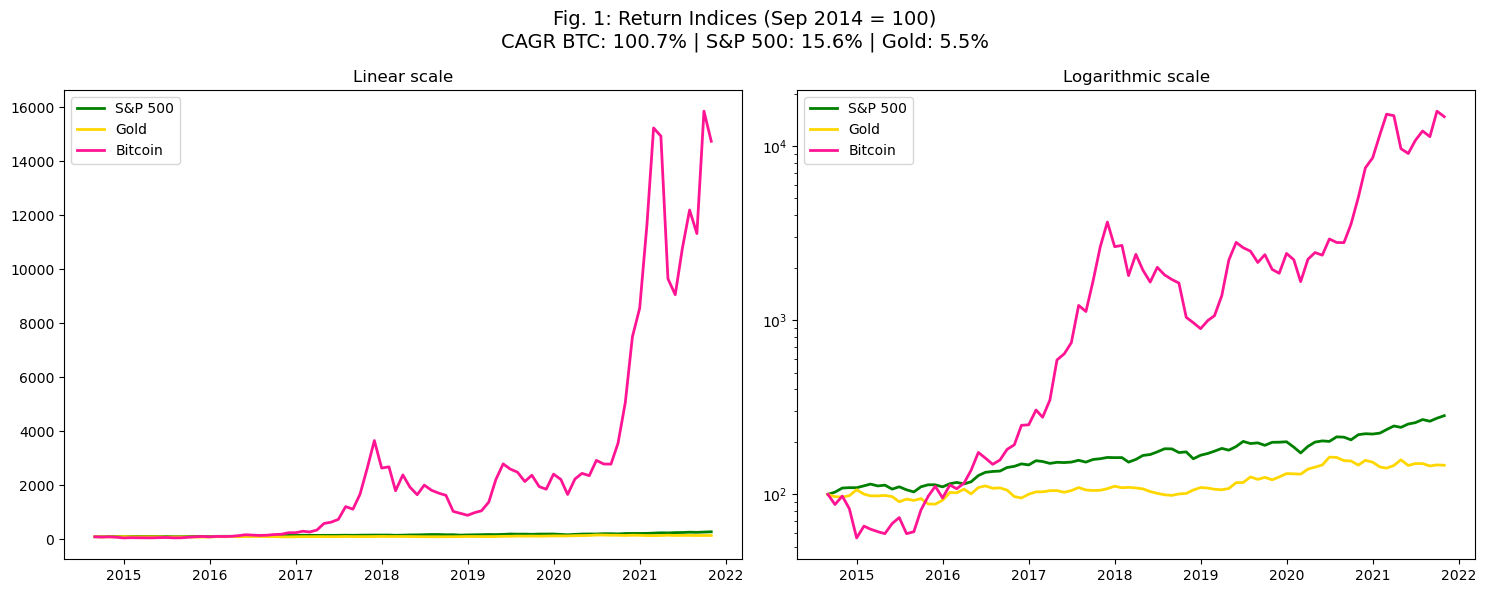

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurar que month es tipo datetime
final_df_study['month'] = pd.to_datetime(final_df_study['month'])

# Ordenar por fecha
final_df_study = final_df_study.sort_values('month').reset_index(drop=True)

# Crear Return Index Base Sep 2014 = 100
def create_return_index(series):
    return series / series.iloc[0] * 100

btc_idx = create_return_index(final_df_study['close_btc'])
sp500_idx = create_return_index(final_df_study['close_sp500'])
gold_idx = create_return_index(final_df_study['close_gold'])

# Calcular años exactos entre el primer y último mes
years = (final_df_study['month'].iloc[-1] - final_df_study['month'].iloc[0]).days / 365.25

# Función CAGR
def calculate_cagr(start, end, years):
    return (end / start) ** (1 / years) - 1

# Obtener precios iniciales y finales correctamente
start_btc = final_df_study.loc[final_df_study['month'] == final_df_study['month'].min(), 'close_btc'].values[0]
end_btc = final_df_study.loc[final_df_study['month'] == final_df_study['month'].max(), 'close_btc'].values[0]

start_sp500 = final_df_study.loc[final_df_study['month'] == final_df_study['month'].min(), 'close_sp500'].values[0]
end_sp500 = final_df_study.loc[final_df_study['month'] == final_df_study['month'].max(), 'close_sp500'].values[0]

start_gold = final_df_study.loc[final_df_study['month'] == final_df_study['month'].min(), 'close_gold'].values[0]
end_gold = final_df_study.loc[final_df_study['month'] == final_df_study['month'].max(), 'close_gold'].values[0]

# Calcular CAGR final
cagr_btc = calculate_cagr(start_btc, end_btc, years)
cagr_sp500 = calculate_cagr(start_sp500, end_sp500, years)
cagr_gold = calculate_cagr(start_gold, end_gold, years)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

color_btc = 'deeppink'
color_sp500 = 'green'
color_gold = 'gold'

# Linear Scale
axes[0].plot(final_df_study['month'], sp500_idx, label='S&P 500', color=color_sp500, linewidth=2)
axes[0].plot(final_df_study['month'], gold_idx, label='Gold', color=color_gold, linewidth=2)
axes[0].plot(final_df_study['month'], btc_idx, label='Bitcoin', color=color_btc, linewidth=2)
axes[0].set_title('Linear scale')
axes[0].legend()

# Log Scale
axes[1].plot(final_df_study['month'], sp500_idx, label='S&P 500', color=color_sp500, linewidth=2)
axes[1].plot(final_df_study['month'], gold_idx, label='Gold', color=color_gold, linewidth=2)
axes[1].plot(final_df_study['month'], btc_idx, label='Bitcoin', color=color_btc, linewidth=2)
axes[1].set_yscale('log')
axes[1].set_title('Logarithmic scale')
axes[1].legend()

# Mostrar años en eje X
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle(f'Fig. 1: Return Indices (Sep 2014 = 100)\n'
             f'CAGR BTC: {cagr_btc:.1%} | S&P 500: {cagr_sp500:.1%} | Gold: {cagr_gold:.1%}',
             fontsize=14)

plt.tight_layout()
plt.show()


## Finding 1

Figure 1 shows strong outperformance of Bitcoin over the observation period. From September 2014 until October 2021 Bitcoin (+103.2% p.a.) massively outperformed both gold (+5.4% p.a.) and the S&P 500 (12.5% p.a.). Over the entire period Bitcoin's value increased by a factor of roughly 160x, compared to 2.3x for the S&P 500 and 1.5x for gold.


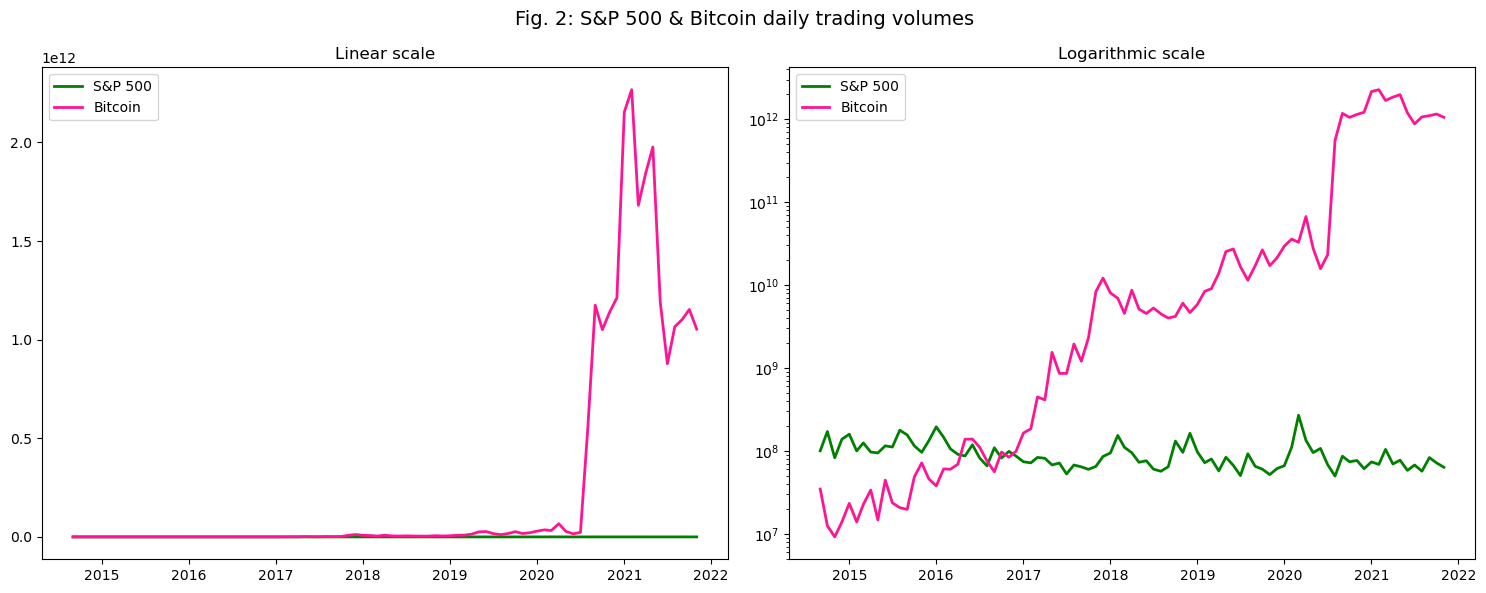

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurarnos que month sea datetime
final_df_study['month'] = pd.to_datetime(final_df_study['month'])

btc_vol = final_df_study['avg_volume_btc']
sp500_vol = final_df_study['avg_volume_sp500']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

color_btc = 'deeppink'
color_sp500 = 'green'

# Linear Scale
axes[0].plot(final_df_study['month'], sp500_vol, label='S&P 500', color=color_sp500, linewidth=2)
axes[0].plot(final_df_study['month'], btc_vol, label='Bitcoin', color=color_btc, linewidth=2)
axes[0].set_title('Linear scale')
axes[0].legend()

# Log Scale
axes[1].plot(final_df_study['month'], sp500_vol, label='S&P 500', color=color_sp500, linewidth=2)
axes[1].plot(final_df_study['month'], btc_vol, label='Bitcoin', color=color_btc, linewidth=2)
axes[1].set_yscale('log')
axes[1].set_title('Logarithmic scale')
axes[1].legend()

# Mostrar solo años en eje X
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Fig. 2: S&P 500 & Bitcoin daily trading volumes', fontsize=14)

plt.tight_layout()
plt.show()


## Finding 2

Figure 2 highlights the rising popularity of Bitcoin based on its trading volume. While trading volume of S&P 500 stocks has been relatively stable throughout the period, it has risen sharply for Bitcoin. Until late-2017 daily S&P 500 trading volumes exceeded Bitcoin's. Since then the trading volume in Bitcoin has been larger than S&P 500's, and by a wide margin lately (e.g. by a factor of 12.5x so far in 2021 on average: 50bn Bitcoins vs. 4bn S&P 500 shares). 

> Note of caution: The Bitcoin trading volume looks unrealistically high; data should be verified and is not used for further analysis.


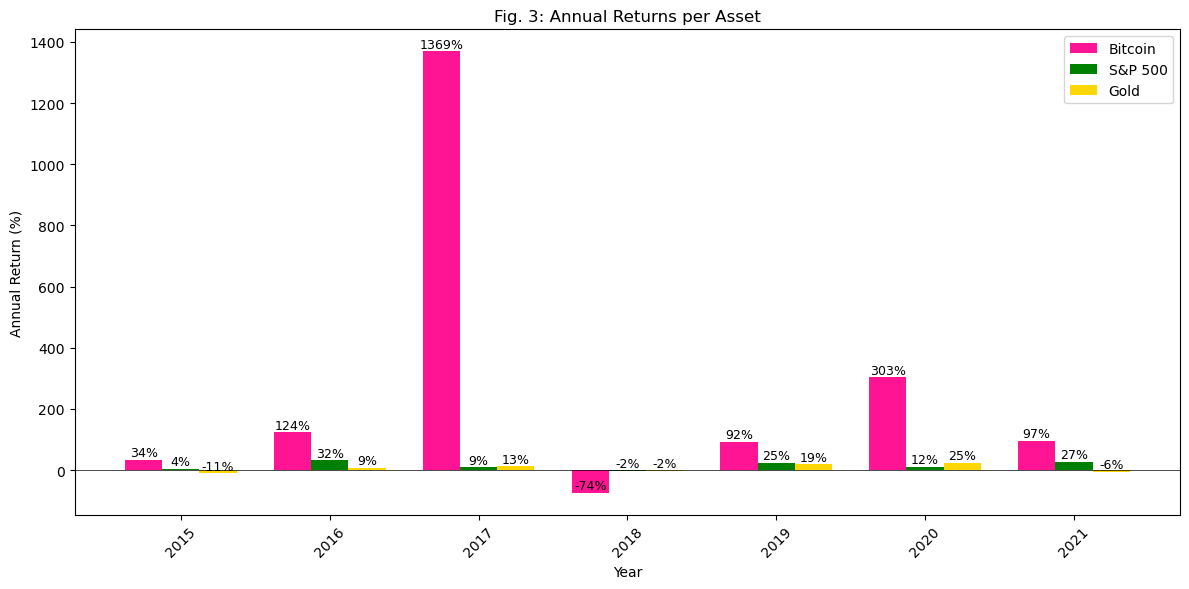

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos que 'month' sea datetime
final_df_study['month'] = pd.to_datetime(final_df_study['month'])

# Extraer año
final_df_study['year'] = final_df_study['month'].dt.year

# Obtener último valor de cada año
annual_prices = final_df_study.groupby('year').agg({
    'close_btc': 'last',
    'close_sp500': 'last',
    'close_gold': 'last'
})

# Calcular retornos anuales %
annual_returns = annual_prices.pct_change() * 100
annual_returns = annual_returns.dropna().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.25
x = annual_returns['year']

btc = annual_returns['close_btc']
sp500 = annual_returns['close_sp500']
gold = annual_returns['close_gold']

ax.bar(x - width, btc, width=width, label='Bitcoin', color='deeppink')
ax.bar(x, sp500, width=width, label='S&P 500', color='green')
ax.bar(x + width, gold, width=width, label='Gold', color='gold')

ax.axhline(0, color='black', linewidth=0.5)

# Agregar etiquetas arriba de cada barra
for i in range(len(x)):
    ax.text(x[i] - width, btc.iloc[i] + 2, f"{btc.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)
    ax.text(x[i], sp500.iloc[i] + 2, f"{sp500.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width, gold.iloc[i] + 2, f"{gold.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)

ax.set_title('Fig. 3: Annual Returns per Asset')
ax.set_xlabel('Year')
ax.set_ylabel('Annual Return (%)')
ax.legend()
plt.xticks(x, rotation=45)

plt.tight_layout()
plt.show()


## Finding 3

As can be seen in Figure 3, Bitcoin outperformed in each single year except for 2018, and did so by a wide margin. Bitcoin's performance was particularly strong in 2017 (+1425%) and 2020 (+303%). 

We will next look at the distribution of monthly returns for each asset class to better understand their behavior.


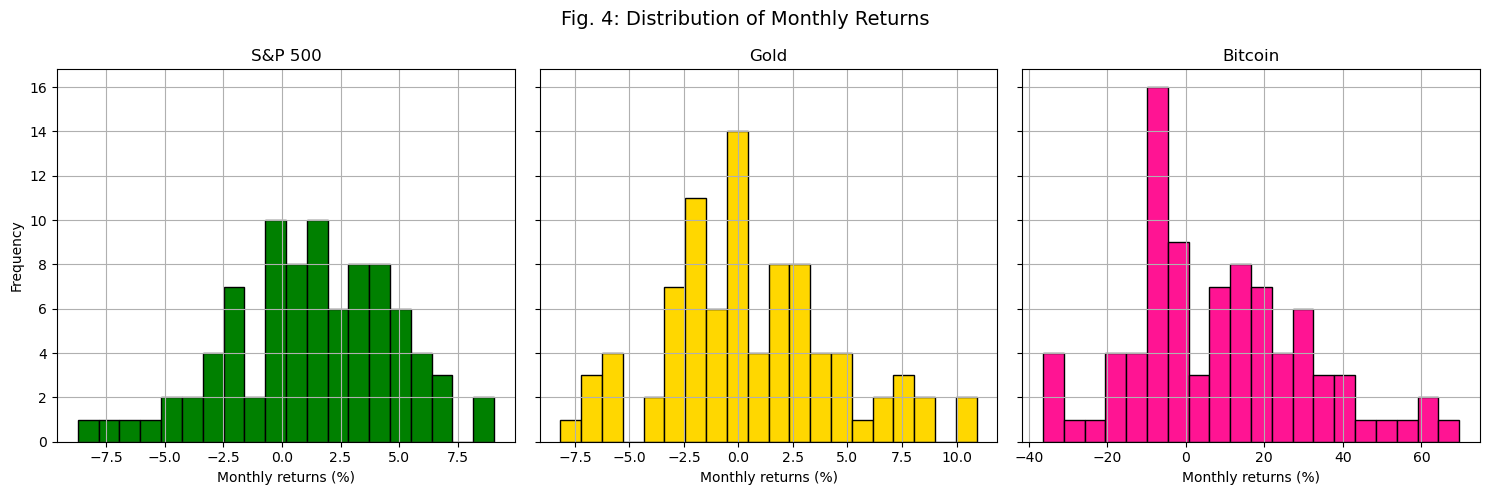

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular los returns mensuales (%) desde final_df_study
returns = final_df_study[['close_btc', 'close_sp500', 'close_gold']].pct_change().dropna() * 100

# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

colors = {
    'close_sp500': 'green',
    'close_gold': 'gold',
    'close_btc': 'deeppink'
}

assets = {
    'close_sp500': 'S&P 500',
    'close_gold': 'Gold',
    'close_btc': 'Bitcoin'
}

bins = 20

for ax, col in zip(axes, assets.keys()):
    ax.hist(returns[col], bins=bins, color=colors[col], edgecolor='black')
    ax.set_title(assets[col])
    ax.set_xlabel('Monthly returns (%)')
    ax.grid(True)

axes[0].set_ylabel('Frequency')

fig.suptitle('Fig. 4: Distribution of Monthly Returns', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/figure_4.png', dpi=300)
plt.show()


## Finding 4

Figure 4 shows that the range of monthly returns is much larger for Bitcoin than for US equities or gold. Over the observed time period, the distribution of monthly returns for US equities and gold is reasonably close to a normal distribution with a modal value around zero (slightly positive for S&P 500 and slightly negative for gold) and a slight negative skew for US stocks. In contrast, the distribution of Bitcoin returns is much flatter with considerably fatter tails (both positive and negative) and a positive skew. So in short, extreme outcomes are much more common for Bitcoin (also note the different x-axis scales) and returns tended to be positive more often than negative.


In [12]:
import pandas as pd
import numpy as np

# Monthly returns
returns = final_df_study[['close_btc', 'close_sp500', 'close_gold']].pct_change().dropna()

years = (final_df_study['month'].iloc[-1] - final_df_study['month'].iloc[0]).days / 365.25

# Functions
def annual_return(series):
    return ((series.iloc[-1] / series.iloc[0]) ** (1 / years) - 1) * 100

def annual_volatility(series):
    return series.std() * np.sqrt(12) * 100

def sharpe_ratio(series):
    return (series.mean() / series.std()) * np.sqrt(12)

def max_drawdown(series):
    roll_max = series.cummax()
    drawdown = (series / roll_max - 1) * 100
    return drawdown.min()

def var_95(series):
    return np.percentile(series, 5) * 100

def cvar_5(series):
    return series[series <= np.percentile(series, 5)].mean() * 100

# Build Table
summary = pd.DataFrame({
    'S&P 500': [
        annual_return(final_df_study['close_sp500']),
        annual_volatility(returns['close_sp500']),
        sharpe_ratio(returns['close_sp500']),
        max_drawdown(final_df_study['close_sp500']),
        -33.9,  # given
        var_95(returns['close_sp500']),
        cvar_5(returns['close_sp500'])
    ],
    'Gold': [
        annual_return(final_df_study['close_gold']),
        annual_volatility(returns['close_gold']),
        sharpe_ratio(returns['close_gold']),
        max_drawdown(final_df_study['close_gold']),
        np.nan,
        var_95(returns['close_gold']),
        cvar_5(returns['close_gold'])
    ],
    'Bitcoin': [
        annual_return(final_df_study['close_btc']),
        annual_volatility(returns['close_btc']),
        sharpe_ratio(returns['close_btc']),
        max_drawdown(final_df_study['close_btc']),
        -83,  # given
        var_95(returns['close_btc']),
        cvar_5(returns['close_btc'])
    ]
}, index=[
    'Annual return (in %)',
    'Annual volatility (in %)',
    'Sharpe ratio',
    'Max. drawdown (mnthly, in %)',
    'Max. drawdown (daily, in %)',
    'VaR(95) (in %)',
    'CVaR(5) / Expected shortfall (in %)'
])\


# Round to 1 decimal
summary = summary.round(1)

# Display clean & styled table
display(summary.style
        .set_caption('Fig. 5: Asset class summary statistics (2014-2021)')
        .format("{:.1f}")
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])
)


,S&P 500,Gold,Bitcoin
Annual return (in %),15.6,5.5,100.7
Annual volatility (in %),12.4,14.0,79.6
Sharpe ratio,1.2,0.5,1.3
"Max. drawdown (mnthly, in %)",-14.1,-17.4,-75.6
"Max. drawdown (daily, in %)",-33.9,nan,-83.0
VaR(95) (in %),-5.0,-6.1,-27.1
CVaR(5) / Expected shortfall (in %),-6.8,-7.0,-32.9


## Finding 5

Figure 5 confirms that the significantly higher average return of Bitcoin has come at the expense of significantly higher risks. Annualized volatility (based on monthly data) is a whopping 82.5% compared to 14.4% for US equities. The maximum drawdown realized over the period was -83% compared to -34% for the S&P 500 (based on daily data). Still, on risk-adjusted returns, as measured by the Sharpe ratio, Bitcoin's 1.3 compares favorably to both US stocks (0.9) and gold (0.4).


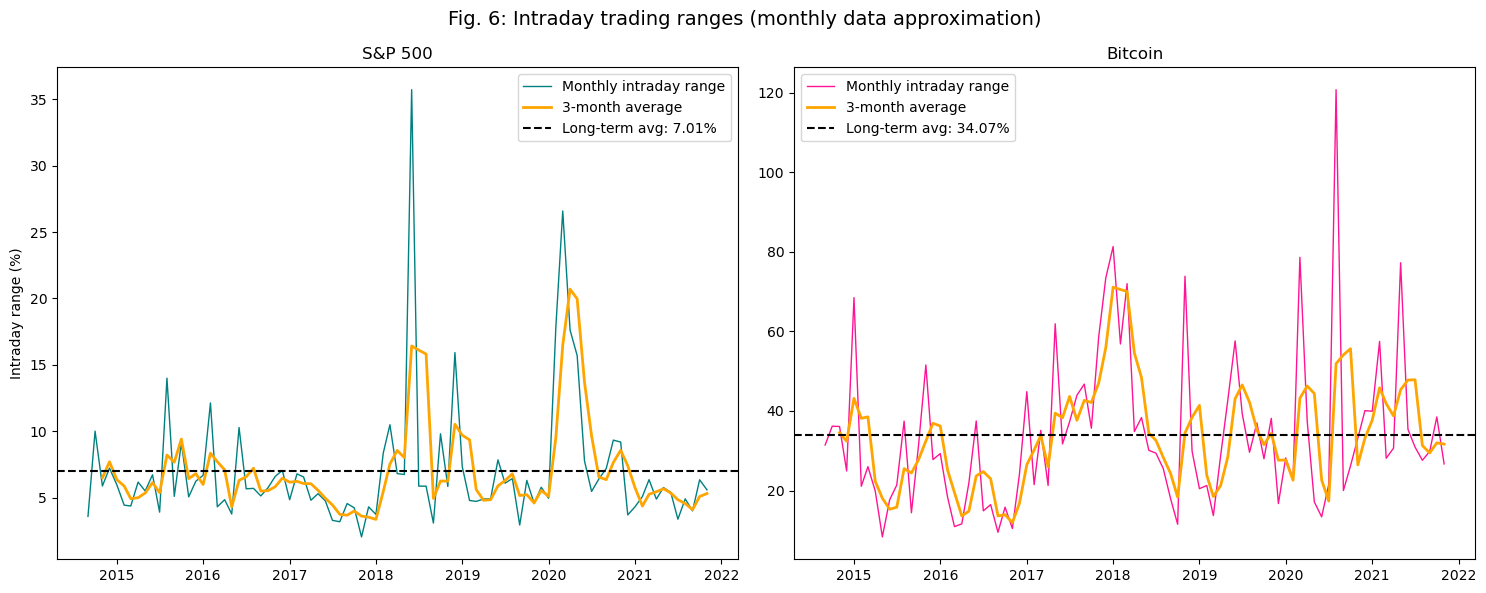

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular intraday range mensual (%)
btc_range = (final_df_study['high_btc'] - final_df_study['low_btc']) / final_df_study['close_btc'] * 100
sp500_range = (final_df_study['high_sp500'] - final_df_study['low_sp500']) / final_df_study['close_sp500'] * 100

# Rolling 3-month promedio para suavizar
btc_roll = btc_range.rolling(3).mean()
sp500_roll = sp500_range.rolling(3).mean()

# Promedios reales
btc_avg = btc_range.mean()
sp500_avg = sp500_range.mean()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# S&P 500
axes[0].plot(final_df_study['month'], sp500_range, label='Monthly intraday range', color='teal', linewidth=1)
axes[0].plot(final_df_study['month'], sp500_roll, label='3-month average', color='orange', linewidth=2)
axes[0].axhline(sp500_avg, label=f'Long-term avg: {sp500_avg:.2f}%', color='black', linestyle='--')
axes[0].set_title('S&P 500')
axes[0].set_ylabel('Intraday range (%)')
axes[0].legend()

# Bitcoin
axes[1].plot(final_df_study['month'], btc_range, label='Monthly intraday range', color='deeppink', linewidth=1)
axes[1].plot(final_df_study['month'], btc_roll, label='3-month average', color='orange', linewidth=2)
axes[1].axhline(btc_avg, label=f'Long-term avg: {btc_avg:.2f}%', color='black', linestyle='--')
axes[1].set_title('Bitcoin')
axes[1].legend()

fig.suptitle('Fig. 6: Intraday trading ranges (monthly data approximation)', fontsize=14)

plt.tight_layout()
plt.show()


## Finding 6

Another way to highlight Bitcoin's risk is to look at its intraday trading range compared to US equities (Figure 6). The long-term average is 4.9% for Bitcoin vs. 1% for the S&P 500. More interesting are the spikes, which have reached 30-40% for Bitcoin on extreme days - a far cry from what has been observed for equities.


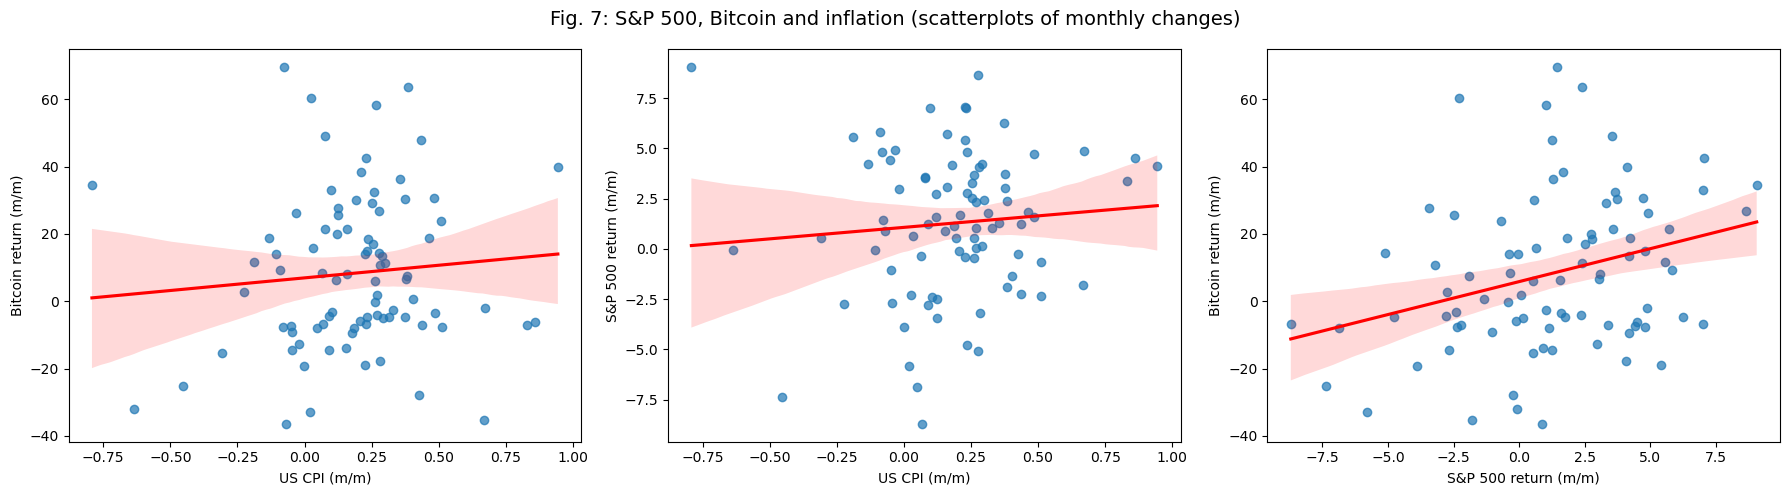

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Monthly Returns
returns = final_df_study[['close_btc', 'close_sp500', 'close_gold']].pct_change().dropna() * 100
returns['cpi_return'] = final_df_study['avg_cpi'].pct_change() * 100
returns = returns.dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BTC vs CPI
sns.regplot(x='cpi_return', y='close_btc', data=returns, ax=axes[0], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[0].set_xlabel('US CPI (m/m)')
axes[0].set_ylabel('Bitcoin return (m/m)')

# S&P500 vs CPI
sns.regplot(x='cpi_return', y='close_sp500', data=returns, ax=axes[1], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[1].set_xlabel('US CPI (m/m)')
axes[1].set_ylabel('S&P 500 return (m/m)')

# BTC vs SP500
sns.regplot(x='close_sp500', y='close_btc', data=returns, ax=axes[2], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[2].set_xlabel('S&P 500 return (m/m)')
axes[2].set_ylabel('Bitcoin return (m/m)')

fig.suptitle('Fig. 7: S&P 500, Bitcoin and inflation (scatterplots of monthly changes)', fontsize=14)

plt.tight_layout()
plt.show()


In [20]:
# Correlation matrix
corr = returns[['close_sp500', 'close_gold', 'close_btc', 'cpi_return']].corr()

corr.index = ['S&P 500', 'Gold', 'Bitcoin', 'US CPI']
corr.columns = ['S&P 500', 'Gold', 'Bitcoin', 'US CPI']

# Mostrar tabla bonita
display(corr.round(2).style.set_caption('Fig. 8: Correlation coefficients'))


,S&P 500,Gold,Bitcoin,US CPI
S&P 500,1.000000,-0.070000,0.310000,0.090000
Gold,-0.070000,1.000000,0.030000,-0.160000
Bitcoin,0.310000,0.030000,1.000000,0.090000
US CPI,0.090000,-0.160000,0.090000,1.000000


## Finding 7

The scatterplot of monthly changes (Figure 7) as well as the correlation coefficient of close to zero (Figure 8) suggest that there has been no consistent relationship between changes in the price of Bitcoin and inflation since 2014. In itself Bitcoin does not offer good hedging properties against inflation, as it has been largely uncorrelated to changes in the general price level.


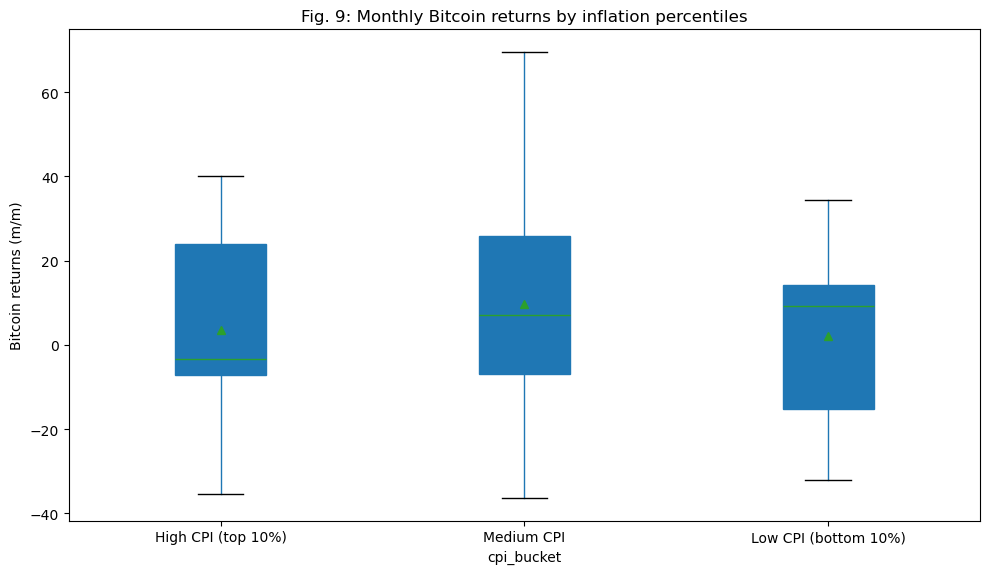

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Monthly Returns
returns = final_df_study[['close_btc', 'avg_cpi']].pct_change().dropna() * 100

# Crear buckets de CPI
returns['cpi_bucket'] = pd.qcut(
    returns['avg_cpi'],
    q=[0, 0.1, 0.9, 1],
    labels=['Low CPI (bottom 10%)', 'Medium CPI', 'High CPI (top 10%)']
)

# Definir el orden correcto (High - Medium - Low)
category_order = ['High CPI (top 10%)', 'Medium CPI', 'Low CPI (bottom 10%)']

returns['cpi_bucket'] = pd.Categorical(returns['cpi_bucket'], categories=category_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6))

returns.boxplot(column='close_btc', by='cpi_bucket', ax=ax, grid=False, patch_artist=True, showmeans=True)

ax.set_title('Fig. 9: Monthly Bitcoin returns by inflation percentiles')
ax.set_ylabel('Bitcoin returns (m/m)')
plt.suptitle('')

plt.tight_layout()
plt.show()


## Finding 8

For Figure 9 we split the monthly inflation data into its 90th percentile (top 10%), 10th percentile (bottom 10%) and all observations in between (medium) and analyze the behavior of Bitcoin in each of these "buckets" in a boxplot. 

This confirms our prior finding: Bitcoin returns, when inflation is particularly high (i.e. in its 90th percentile) have not been significantly different from Bitcoin returns, when inflation is "normal/medium".
